# Sentiment Analysis on Movie Reviews

In [1]:
import os
import string
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

import nltk

import unicodedata, re

## Preparation and analisys of data

In [2]:
# load data
train = pd.read_csv('train.tsv', '\t')
test = pd.read_csv('test.tsv', '\t')

In [3]:
# shapes of datasets
print("Train :",train.shape)
print("Test:",test.shape)

Train : (156060, 4)
Test: (66292, 3)


In [4]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Колонка ['Sentiment'] містить оцінку коментаря (від 0 до 4). Відповідно:

0 - негативний;
1 - трохи негативний;
2 - нейтральний;
3 - трохи позитивний;
4 - позитивний.

In [5]:
train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [6]:
# get columns with NULLs  (if exist)
train.columns[train.isna().any()].tolist()

[]

Оглянемо, скільки фраз належить до одного речення (наприклад, до речення 2):

In [7]:
sentence_2 = train.loc[train['SentenceId'] == 2]
print(len(sentence_2))
sentence_2

18


,PhraseId,SentenceId,Phrase,Sentiment
63,64,2,"This quiet , introspective and entertaining in...",4
64,65,2,"This quiet , introspective and entertaining in...",3
65,66,2,This,2
66,67,2,"quiet , introspective and entertaining indepen...",4
67,68,2,"quiet , introspective and entertaining",3
68,69,2,quiet,2
69,70,2,", introspective and entertaining",3
70,71,2,introspective and entertaining,3
71,72,2,introspective and,3
72,73,2,introspective,2


In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [9]:
test.columns[test.isna().any()].tolist()

[]

І в тренувальному, і в тестувальному датасеті відсутні нульові значення, тому не потрібно виконувати їхню додаткову обробку.

Відслідкуємо кількість фраз за оцінкою:

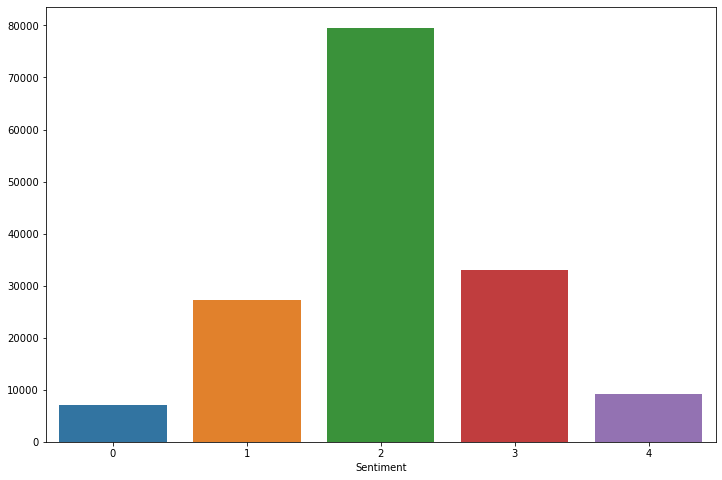

In [10]:
dist = train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

Оскільки на оцінку коментаря (негативний/позитивний) впливають лише слова у фразі, то саме з них і сформуємо матрицю властивостей (feature matrix).

In [11]:
words = train['Phrase'].apply(nltk.word_tokenize)

Нормалізуємо дані:

In [12]:
# Remove non-ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# All words to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove punctuation
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove all numbers
def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    return words

In [13]:
words = words.apply(normalize) 
words.head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Phrase, dtype: object

Створимо словник унікальних слів:

In [14]:
word_set = set()
for l in words:
    for e in l:
        word_set.add(e)
        
vocabulary = {word: ii for ii, word in enumerate(word_set, 1)}
vocabulary

{'mission': 1,
 'deftly': 2,
 'illuminate': 3,
 'fifteenminute': 4,
 'actress': 5,
 'undramatic': 6,
 'lola': 7,
 'wisegirls': 8,
 'timeitis': 9,
 'facet': 10,
 'amazement': 11,
 'foot': 12,
 'twofifths': 13,
 'gamut': 14,
 'sitcomishly': 15,
 'shaken': 16,
 'obligatory': 17,
 'unsympathetic': 18,
 'drew': 19,
 'transform': 20,
 'terminal': 21,
 'inescapably': 22,
 'conscious': 23,
 'indignation': 24,
 'swear': 25,
 'avenues': 26,
 'breaks': 27,
 'elbowed': 28,
 'imaginative': 29,
 'uncover': 30,
 'denzel': 31,
 'drowns': 32,
 'mendes': 33,
 'dalloway': 34,
 'pillages': 35,
 'unnecessary': 36,
 'canon': 37,
 'orientation': 38,
 'celebrated': 39,
 'billy': 40,
 'horror': 41,
 'france': 42,
 'funniness': 43,
 'share': 44,
 'undergraduate': 45,
 'audacity': 46,
 'dramedy': 47,
 'morphs': 48,
 'depend': 49,
 'groupies': 50,
 'shiver': 51,
 'cd': 52,
 'distinguishing': 53,
 'orlando': 54,
 'clive': 55,
 'appalling': 56,
 'lear': 57,
 'flash': 58,
 'words': 59,
 'promotes': 60,
 'fincher': 6

Закодуємо фрази відповідно до словника:

In [15]:
tokens = words.apply(lambda l: [vocabulary[word] for word in l])
tokens.head()

0    [5051, 9606, 16001, 9355, 4084, 10604, 9518, 9...
1    [5051, 9606, 16001, 9355, 4084, 10604, 9518, 9...
2                                         [5051, 9606]
3                                               [5051]
4                                               [9606]
Name: Phrase, dtype: object

Створюємо матрицю властивостей. Оскільки масиви токенів є різної розмірності, то зрівняємо їх, дописуючи  нулі наприкінці:

In [16]:
# The longest phrase
max_len = tokens.str.len().max()
print(max_len)

all_tokens = np.array([t for t in tokens])
features = np.zeros((len(all_tokens), max_len), dtype=int)
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

# Print first 5 values of the feature matrix 
features[:5]

48


array([[ 5051,  9606, 16001,  9355,  4084, 10604,  9518,  9992,  7553,
         2327,  1977,  4723, 10604,   312,  2327, 13845,  1977,  4723,
        10604,  5269, 10461, 16001, 12583,  9330,  6631,  8636, 15855,
        16001, 12583, 13493, 11583, 15632, 16001,  5051, 13281,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 5051,  9606, 16001,  9355,  4084, 10604,  9518,  9992,  7553,
         2327,  1977,  4723, 10604,   312,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 5051,  9606,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   

Варто зазначити, що побудова графіків кореляції між властивостями (колонками) не має сенсу, адже властивості жодним чином не впливають одна на одну.

Оскільки ми вирішуємо задачу логістичної регресії (бінарної класифікації), то замінимо значення оцінок на 0 і 1 за таким принципом: 0-1 позначимо як 0 (негативний), а 2-4 - як 1(позитивний; нейтральні коментарі теж вважатиемо позитивними).

In [17]:
target = train["Sentiment"].apply(lambda i: 0 if i < 2 else 1)
target

0         0
1         1
2         1
3         1
4         1
         ..
156055    1
156056    0
156057    1
156058    1
156059    1
Name: Sentiment, Length: 156060, dtype: int64

##  Algorithm selection

Split data to train and test

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, shuffle = True, stratify = target)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((124848, 48), (124848,), (31212, 48), (31212,))

Hyperparameters:

In [19]:
alpha = 0.05
max_iters = 1000

## 1. Sklearn classifier

In [20]:
clf = LogisticRegression(solver='lbfgs', max_iter=max_iters, tol=1e-10)
clf = clf.fit(X_train, Y_train)

c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)

### Results evaluation for training data:

In [22]:
# Accuracy
acc_scr = accuracy_score(Y_train, Y_train_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = confusion_matrix(Y_train, Y_train_pred)
print("Confusion Matrix:\nPredicted\t0\t1\nActual\n0\t\t{}\t{}\n1\t\t{}\t{}".format(conf_mtrx[0][0], conf_mtrx[0][1],conf_mtrx[1][0],conf_mtrx[1][1]))

# Precision
prec = precision_score(Y_train, Y_train_pred)
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = recall_score(Y_train, Y_train_pred)
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.77844

Confusion Matrix:
Predicted	0	1
Actual
0		299	27177
1		484	96888

Precision: 0.78095

Recall: 0.99503


### Results evaluation for test data:

In [23]:
# Accuracy
acc_scr = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = confusion_matrix(Y_test, Y_test_pred)
print("Confusion Matrix:\nPredicted\t0\t1\nActual\n0\t\t{}\t{}\n1\t\t{}\t{}".format(conf_mtrx[0][0], conf_mtrx[0][1],conf_mtrx[1][0],conf_mtrx[1][1]))

# Precision
prec = precision_score(Y_test, Y_test_pred)
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = recall_score(Y_test, Y_test_pred)
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.77851

Confusion Matrix:
Predicted	0	1
Actual
0		76	6793
1		120	24223

Precision: 0.78098

Recall: 0.99507


## 2. Custom realization

In [24]:
def normalize(X):
    mean = np.mean(X)
    std = np.std(X)
    X_new = (X - mean) / std
    return X_new, mean, std

In [25]:
def prepare_X(X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.column_stack((ones, X))
    return X_new

In [26]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

In [27]:
def h(X, theta):
    z = np.dot(X, theta)
    return sigmoid(z)

In [28]:
def cost_function(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    
    J = (-y * np.log(h(X, theta)) - (1 - y) * np.log(1 - h(X, theta))).mean()
    
    return J

In [29]:
def derivative_theta(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None

    d_theta = np.dot(X.T, (h(X, theta) - y)) / m
    
    return d_theta

In [30]:
def gradient_descent(X, y, theta, alpha, epsilon, num_iters, print_J = True):
    m = X.shape[0]
    J_history = []
    
    J = cost_function(X, y, theta)
    
    if print_J == True:
        print(J)
    J_history.append(J)
    for i in range(num_iters):
        
        delta = derivative_theta(X, y, theta)
        theta = theta - alpha * delta
        
        J = cost_function(X, y, theta)
        
        J_history.append(J)
        
        if i % 1000 == 0 and print_J == True:
            print(J)
        
        if abs(J-J_history[-2]) < epsilon:
            break
            
    return theta, J_history

In [31]:
def predict(X, theta):
    X_test_proc = prepare_X(X)
    predictions = h(X_test_proc, theta)
    return predictions.round(0)

Hyperparameters:

In [32]:
alpha = 0.01
max_iters = 100000

In [33]:
X_new, mean, std = normalize(X_train)

In [34]:
X_new = prepare_X(X_new)
Y_new = Y_train.values.reshape((X_train.shape[0], 1))

In [35]:
#theta = np.zeros((X_new.shape[1], 1))
theta = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
theta.shape[0]

49

In [36]:
new_theta, Js = gradient_descent(X_new, Y_train, theta, alpha, 1e-7, max_iters, False)
print(new_theta, len(Js))

[ 0.76952107  0.03013006 -0.00289988 -0.03841137 -0.06337455 -0.04375283
 -0.053813   -0.05694411 -0.04450165 -0.02912933 -0.0326578  -0.01906393
 -0.01331566 -0.01096458 -0.00522701 -0.01672952 -0.00671365 -0.00642675
 -0.0062127  -0.01430794 -0.0351233   0.00539657  0.01165963 -0.00612765
 -0.0157313  -0.00887422 -0.01367698  0.00209491  0.00698563  0.03109192
  0.05475777  0.02886177  0.05314273  0.01398162 -0.00988267 -0.03908758
 -0.04421933 -0.06468078 -0.09213595 -0.0838834  -0.13108594 -0.16674306
 -0.19281795 -0.2079626  -0.23422611 -0.23537826 -0.25778189 -0.26394997
 -0.26674429] 9227


In [37]:
Y_train_pred = predict(X_train, new_theta)
print(Y_train_pred)

[1. 1. 1. ... 1. 0. 1.]


c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [38]:
Y_test_pred = predict(X_test, new_theta)
print(Y_test_pred)

[0. 1. 0. ... 1. 1. 0.]


c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


### Results evaluation for training data:

In [39]:
# Accuracy
acc_scr = accuracy_score(Y_train, Y_train_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = pd.crosstab(Y_train, Y_train_pred, rownames=['Actual'], colnames=['Predicted'])
print("\tConfusion Matrix:\n{}".format(conf_mtrx))

# Precision
prec = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[1][0])
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[0][1])
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.46869

	Confusion Matrix:
Predicted    0.0    1.0
Actual                 
0          21781   5695
1          60638  36734

Precision: 0.86578

Recall: 0.37725


### Results evaluation for test data:

In [40]:
# Accuracy
acc_scr = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = pd.crosstab(Y_test, Y_test_pred, rownames=['Actual'], colnames=['Predicted'])
print("\tConfusion Matrix:\n{}".format(conf_mtrx))

# Precision
prec = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[1][0])
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[0][1])
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.47110

	Confusion Matrix:
Predicted    0.0   1.0
Actual                
0           5460  1409
1          15099  9244

Precision: 0.86774

Recall: 0.37974
